In [1]:
# Python Libraries
import numpy as np
from scipy import stats
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import missingno as msno
import seaborn as sns
from datetime import date,datetime, timedelta
import os
import sys
import requests
import json

import warnings
warnings.filterwarnings('ignore') 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Loan Application

## We would like to know:
1. How does the conversion rate change over time? Are we doing better or worse? In particular, what about loans from the last 30 or last 60 days?
2. What about the time to conversion? Are people converting faster or does it take longer?


In [4]:
df = pd.read_csv("data/loans.csv", sep=",", names=["amount", "address", "created", "funded"])
print("Number of rows:",len(df))
df.head()

Number of rows: 5143


,amount,address,created,funded
0,568705.000,"22226 Brookpine, Mission Viejo CA 92692",2016-12-20T07:16:04.778800+00:00,NaN
1,413165.000,"124 Vignolia Court, Roseville CA 95747",2016-10-11T20:35:19.951835+00:00,2016-11-07T00:00:00+00:00
2,584083.000,"13909 Via Del Jamul Dr, Jamul CA 91935",2017-08-08T03:23:04.349419+00:00,NaN
3,258680.000,"13209 N Mayfair Ln, Spokane WA 99208",2017-05-25T19:06:01.525985+00:00,NaN
4,170180.000,"205 Cottontail Ln, Elkin NC 28621",2017-03-02T19:40:13.319275+00:00,NaN


In [5]:
df["created"] = pd.to_datetime(df["created"])
df["created"] = df["created"].values.astype("datetime64[D]")
df["funded"] = pd.to_datetime(df["funded"])
df["funded"] = df["funded"].values.astype("datetime64[D]")

In [6]:
df.head(5)

,amount,address,created,funded
0,568705.000,"22226 Brookpine, Mission Viejo CA 92692",2016-12-20,NaT
1,413165.000,"124 Vignolia Court, Roseville CA 95747",2016-10-11,2016-11-07
2,584083.000,"13909 Via Del Jamul Dr, Jamul CA 91935",2017-08-08,NaT
3,258680.000,"13209 N Mayfair Ln, Spokane WA 99208",2017-05-25,NaT
4,170180.000,"205 Cottontail Ln, Elkin NC 28621",2017-03-02,NaT


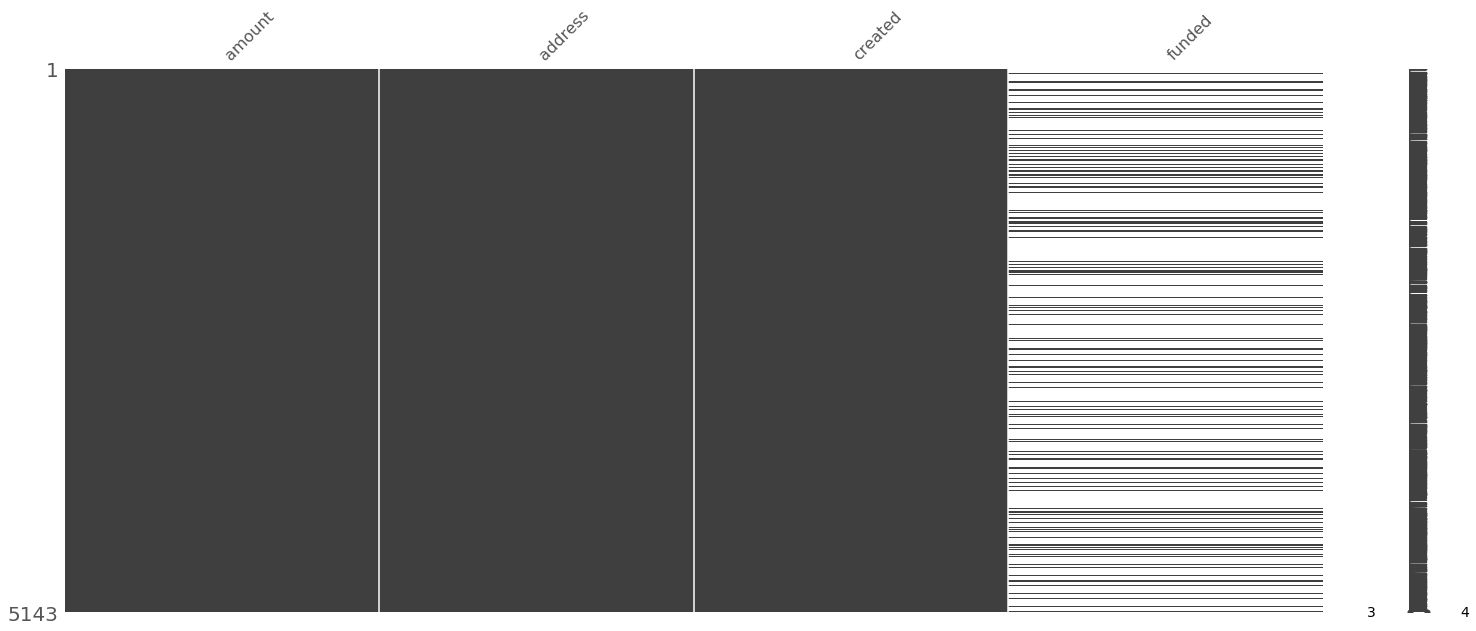

In [7]:
msno.matrix(df);

In [8]:
# Computing missing data. 
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head()

,Total,Percent
funded,4088,79.487
created,0,0.000
address,0,0.000
amount,0,0.000


In [9]:
df.describe()

,amount
count,5143.000
mean,382389.443
std,1271107.565
min,9.000
25%,216656.500
50%,317937.000
75%,421659.000
max,57762492.000


In [10]:
z = stats.zscore(df["amount"])
print(np.where( z > 3))

(array([2443, 2519, 2774, 3555]),)


In [11]:
print(z[2443], z[2519], z[2774], z[3555])

38.40051034673434 7.209318674283304 37.9288482263481 45.14620432901849


In [12]:
std = np.std(df["amount"])
mean = np.mean(df["amount"])
print(mean, std)

382389.44273770176 1270983.982154629


In [13]:
amount_1std = df[df["amount"] > (mean + std)]

In [14]:
len(amount_1std)

12

In [15]:
amount_1std

,amount,address,created,funded
680,1801514.000,"254-266 The Embarcadero, SF CA 94105",2017-02-27,NaT
1653,2750000.000,"6403 S Uvalda St, Centennial CO 80111",2017-08-17,NaT
1845,1977055.000,"1160 Lammy Pl, Los Altos CA 94024",2016-12-31,NaT
2147,1762186.000,"38 Miltiades Ave, Greenwich CT 06878",2017-10-09,NaT
2399,2150000.000,"1332 Davies Dr, Beverly Hills CA 90210",2016-12-15,NaT
2443,49188823.000,"1 Ave at Port Imperial, West New York NJ 07093",2016-12-31,NaT
2519,9545318.000,"4426 Triggs St, Los Angeles CA 90040",2017-10-06,NaT
2673,2000000.000,"1375-1385 S Los Robles Ave, Pasadena CA 91106",2017-01-16,NaT
2774,48589348.000,"7411 Goen Pl, San Diego CA 92120",2017-01-20,NaT
2839,2405731.000,"1736-1750 8th St, Manhattan Beach CA 90266",2017-01-06,NaT


In [16]:
df = df[df["amount"] <= (mean + std)]

In [17]:
df.describe()

,amount
count,5131.000
mean,347831.394
std,194980.161
min,9.000
25%,216522.000
50%,317373.000
75%,420837.000
max,1650000.000


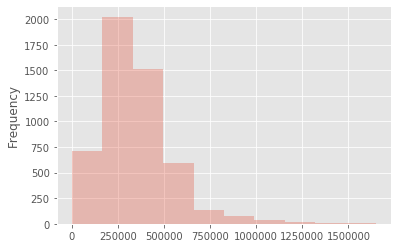

In [18]:
df["amount"].plot.hist(alpha=0.3, stacked=True, bins=10);

In [19]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

amount   204315.000
dtype: float64


In [20]:
Q3 + 1.5 * IQR

amount   727309.500
dtype: float64

In [21]:
df = df[df["amount"] < (Q3[0] + 1.5 * IQR[0])]

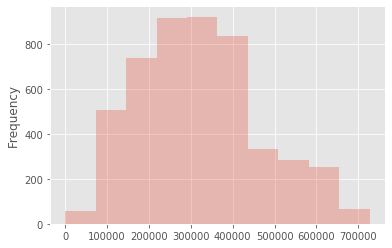

In [22]:
df["amount"].plot.hist(alpha=0.3, stacked=True, bins=10);

In [23]:
df.dtypes

amount            float64
address            object
created    datetime64[ns]
funded     datetime64[ns]
dtype: object

In [24]:
df = df[ df["funded"] > df["created"]]

In [25]:
df["conversion_length_m"] = (df["funded"]-df["created"])/np.timedelta64(1, "M")
df["conversion_length_m"].describe()

count   1046.000
mean       1.625
std        0.755
min        0.526
25%        1.183
50%        1.478
75%        1.906
max       14.128
Name: conversion_length_m, dtype: float64

In [26]:
df["conversion_length_d"] = (df["funded"]-df["created"])/np.timedelta64(1, "D")
df["conversion_length_d"].describe()

count   1046.000
mean      49.467
std       22.970
min       16.000
25%       36.000
50%       45.000
75%       58.000
max      430.000
Name: conversion_length_d, dtype: float64

In [27]:
print("min_created_date:",min(df["created"]))
print("max_created_date:",max(df["created"]))
print("min_funded_date:",min(df["funded"]))
print("max_funded_date:",max(df["funded"]))
print("min_conversion_length(in days):",min(df["conversion_length_d"]))
print("max_conversion_length(in days:",max(df["conversion_length_d"]))

min_created_date: 2016-06-22 00:00:00
max_created_date: 2017-11-06 00:00:00
min_funded_date: 2016-10-26 00:00:00
max_funded_date: 2017-12-23 00:00:00
min_conversion_length(in days): 16.0
max_conversion_length(in days: 430.0


In [28]:
df["converted"] = df["funded"].notnull()

In [29]:
df.head()

,amount,address,created,funded,conversion_length_m,conversion_length_d,converted
1,413165.000,"124 Vignolia Court, Roseville CA 95747",2016-10-11,2016-11-07,0.887,27.000,True
6,504193.000,"10190 Brixton Pl, Suwanee GA 30024",2017-08-18,2017-09-18,1.019,31.000,True
8,275236.000,"1952 S St SE, Washington DC 20020",2017-09-23,2017-11-15,1.741,53.000,True
37,287472.000,"7498 NE 156th St, Kenmore WA 98028",2016-11-21,2016-12-30,1.281,39.000,True
40,254942.000,"3212-3214 W 157th St, Gardena CA 90249",2016-10-01,2016-11-18,1.577,48.000,True


In [30]:
df_no_nan = df.dropna()

In [31]:
df_no_nan.describe()

,amount,conversion_length_m,conversion_length_d
count,1046.000,1046.000,1046.000
mean,340312.466,1.625,49.467
std,117766.746,0.755,22.970
min,75000.000,0.526,16.000
25%,261406.250,1.183,36.000
50%,334104.500,1.478,45.000
75%,405000.000,1.906,58.000
max,699783.000,14.128,430.000


In [32]:
len(df_no_nan)

1046

# Overall even number of people who converted within 50 days or in more that 50 days.
# Among the latter, about 5% have a conversion length greater than 100 days.

In [33]:
print(len(df_no_nan[df_no_nan["conversion_length_d"] < 50]))
print(len(df_no_nan[df_no_nan["conversion_length_d"] > 50]))
print(len(df_no_nan[df_no_nan["conversion_length_d"] > 100]))

619
412
22


In [34]:
22/412

0.05339805825242718

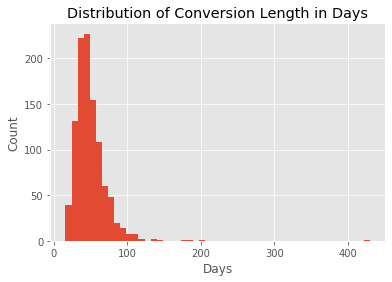

In [35]:
fig, ax = plt.subplots()
df["conversion_length_d"].hist(bins=50)
plt.xlabel("Days")
plt.ylabel("Count")
ax.set_title("Distribution of Conversion Length in Days");

In [36]:
trend_ts_df = df[["funded","conversion_length_d"]]
trend_ts_df = trend_ts_df.sort_values("funded",ascending=True)
trend_ts_df.set_index("funded", inplace=True)
trend_ts_df.head()

,conversion_length_d
funded,
2016-10-26,54.000
2016-10-26,44.000
2016-10-26,62.000
2016-10-26,63.000
2016-10-26,30.000


In [37]:
trend_ts_df_mean = trend_ts_df.groupby("funded").mean()
trend_ts_df_mean.head()

,conversion_length_d
funded,
2016-10-26,49.750
2016-10-27,41.250
2016-10-28,45.333
2016-10-31,42.588
2016-11-01,59.000


# Conversion was more or les monotonic, with an average aorund 50 days of conversion lenght and some peaks at 100 days of conversion.

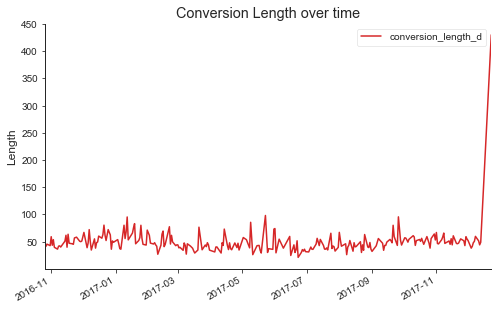

In [38]:
sns.set_style('ticks')
red="#D62728"
fig, ax = plt.subplots(figsize=(8,5))
trend_ts_df_mean["conversion_length_d"].plot(color=red)
ax.set_xlabel("")
ax.set_ylabel("Length")
ax.legend(["conversion_length_d"])
ax.set_title("Conversion Length over time")
ax.set_xticks([], minor=True) 
ax.set_xlim([trend_ts_df_mean.index[0], trend_ts_df_mean.index[-1]])
sns.despine()
plt.show()

# More recently a big surge happened on 2017-12-23 which is driven by a unique customer.

In [39]:
df_no_nan[df_no_nan["conversion_length_d"] == 430]

,amount,address,created,funded,conversion_length_m,conversion_length_d,converted
2486,403000.000,"3465 Trailblazer Way, Carlsbad CA 92010",2016-10-19,2017-12-23,14.128,430.000,True


In [40]:
trend_ts_df.tail()

,conversion_length_d
funded,
2017-12-13,44.000
2017-12-13,69.000
2017-12-13,42.000
2017-12-13,40.000
2017-12-23,430.000


In [41]:
trend_amount_df = df[["amount","conversion_length_d"]]
trend_amount_df = trend_amount_df.sort_values("amount",ascending=True)
trend_amount_df.set_index("amount", inplace=True)
trend_amount_df_mean = trend_amount_df.groupby("amount").mean()

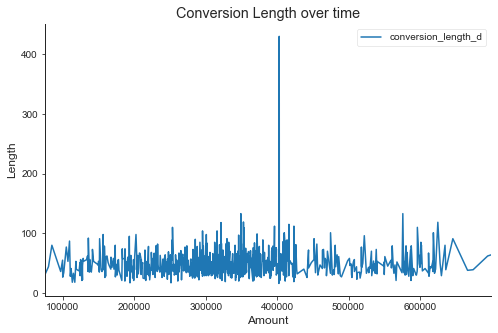

In [42]:
sns.set_style('ticks')
blue='#1F77B4'
fig, ax = plt.subplots(figsize=(8,5))
trend_amount_df_mean["conversion_length_d"].plot(color=blue)
ax.set_xlabel("Amount")
ax.set_ylabel("Length")
ax.legend(["conversion_length_d"])
ax.set_title("Conversion Length over time")
ax.set_xticks([], minor=True) 
ax.set_xlim([trend_amount_df_mean.index[0], trend_amount_df_mean.index[-1]])
sns.despine()
plt.show()

# It does not look like the lenght of conversion is related to the amount of the loan.
# And this customer seems to be unique, wrong entry or not we filter it out.

In [43]:
df_no_nan = df_no_nan[df_no_nan["conversion_length_d"] != 430]
len(df_no_nan)

1045

In [44]:
trend_ts_df = trend_ts_df[trend_ts_df["conversion_length_d"] != 430]

In [45]:
trend_ts_df.index[-1]

Timestamp('2017-12-13 00:00:00')

In [46]:
trend_ts_df_last_30_days = trend_ts_df[trend_ts_df.index >= "2017-11-10"]

In [47]:
trend_ts_df_last_30_days.head()

,conversion_length_d
funded,
2017-11-13,54.000
2017-11-13,28.000
2017-11-13,67.000
2017-11-13,55.000
2017-11-13,52.000


In [48]:
trend_ts_df_last_30_days_mean = trend_ts_df_last_30_days.groupby("funded").mean()
trend_ts_df_last_30_days_mean.head()

,conversion_length_d
funded,
2017-11-13,51.200
2017-11-14,45.000
2017-11-15,55.333
2017-11-16,44.000
2017-11-17,60.667


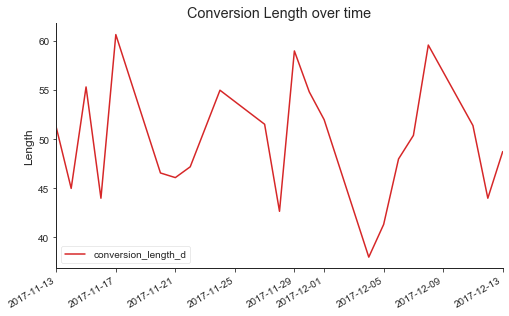

In [49]:
sns.set_style('ticks')
red="#D62728"
fig, ax = plt.subplots(figsize=(8,5))
trend_ts_df_last_30_days_mean["conversion_length_d"].plot(color=red)
ax.set_xlabel("")
ax.set_ylabel("Length")
ax.legend(["conversion_length_d"])
ax.set_title("Conversion Length over time")
ax.set_xticks([], minor=True) 
ax.set_xlim([trend_ts_df_last_30_days_mean.index[0], trend_ts_df_last_30_days_mean.index[-1]])
sns.despine()
plt.show()

# Average time of conversion for last 30 days fluctuating about 40  and 60. No clear trends.

In [50]:
trend_ts_df_last_30_days.index

DatetimeIndex(['2017-11-13', '2017-11-13', '2017-11-13', '2017-11-13',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-15',
               '2017-11-15', '2017-11-16',
               ...
               '2017-12-11', '2017-12-11', '2017-12-11', '2017-12-11',
               '2017-12-12', '2017-12-12', '2017-12-13', '2017-12-13',
               '2017-12-13', '2017-12-13'],
              dtype='datetime64[ns]', name='funded', length=104, freq=None)

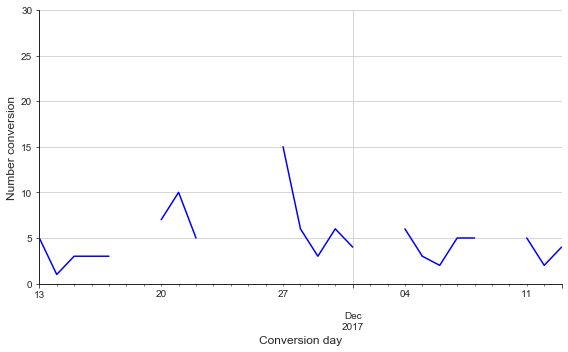

In [51]:
fig, ax = plt.subplots(figsize=(8,5))
trend_df_conversion_rate_30 = trend_ts_df_last_30_days.groupby("funded")["conversion_length_d"].count().resample('D').mean()
trend_df_conversion_rate_30.plot(kind='line',colormap='winter')
plt.ylabel('Number conversion')
plt.xlabel('Conversion day')
#ax.axis('equal')
ax.grid(True)
ax.set_xlim([trend_df_conversion_rate_30.index[0], trend_df_conversion_rate_30.index[-1]])
ax.set_ylim(0, 30)
sns.despine()
plt.tight_layout()

# The last 30 days, rate of conversion is about five, dropping to 0 some days and a peak around November 27th at 15.

In [52]:
trend_ts_df_last_60_days = trend_ts_df[trend_ts_df.index >= "2017-10-10"]
trend_ts_df_last_60_days_mean = trend_ts_df_last_60_days.groupby("funded").mean()

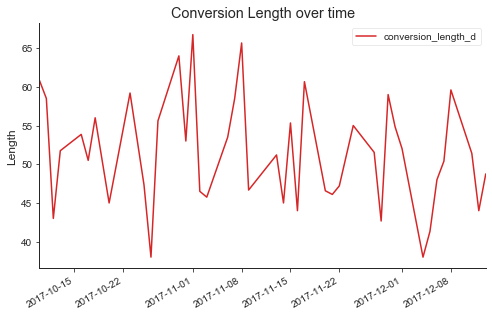

In [53]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(8,5))
trend_ts_df_last_60_days_mean["conversion_length_d"].plot(color=red)
ax.set_xlabel("")
ax.set_ylabel("Length")
ax.legend(["conversion_length_d"])
ax.set_title("Conversion Length over time")
ax.set_xticks([], minor=True) 
ax.set_xlim([trend_ts_df_last_60_days_mean.index[0], trend_ts_df_last_60_days_mean.index[-1]])
sns.despine()
plt.show()

# Conversion length over time similar to the last 30 days.

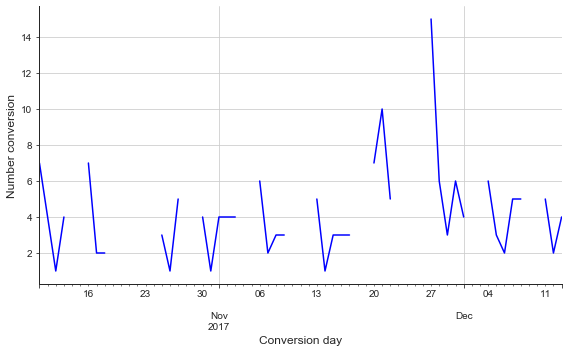

In [54]:
fig, ax = plt.subplots(figsize=(8,5))
trend_df_conversion_rate_60 = trend_ts_df_last_60_days.groupby("funded")["conversion_length_d"].count().resample('D').mean()
trend_df_conversion_rate_60.plot(kind='line',colormap='winter')
plt.ylabel('Number conversion')
plt.xlabel('Conversion day')
ax.grid(True)
ax.set_xlim([trend_df_conversion_rate_60.index[0], trend_df_conversion_rate_60.index[-1]])
#ax.set_ylim(0, 0)
sns.despine()
plt.tight_layout()

# Conversion rate around 6 with two peaks at 10 and 15 for the last 60 days, similar to what is observed for last 30 days.

# Conforming vs Jumbo loans
1. What is the conversion rate from loan application to fund, broken down by conforming vs jumbo?
2. How does it vary over time?
3. How much worse is the conversion rate for jumbo, controlling for the loan amount?
4. What about states? Are there particular states where it looks like our Jumbo has much worse conversion?


In [55]:
loan_limits = pd.read_excel("data/FullCountyLoanLimitList2017_HERA-BASED_FINAL_FLAT.xlsx", header=1)

In [56]:
loan_limits.head()

,FIPS State Code,FIPS County Code,County Name,State,CBSA Number,One-Unit Limit,Two-Unit Limit,Three-Unit Limit,Four-Unit Limit
0,1,1,AUTAUGA,AL,33860.000,424100,543000,656350,815650
1,1,3,BALDWIN,AL,19300.000,424100,543000,656350,815650
2,1,5,BARBOUR,AL,nan,424100,543000,656350,815650
3,1,7,BIBB,AL,13820.000,424100,543000,656350,815650
4,1,9,BLOUNT,AL,13820.000,424100,543000,656350,815650


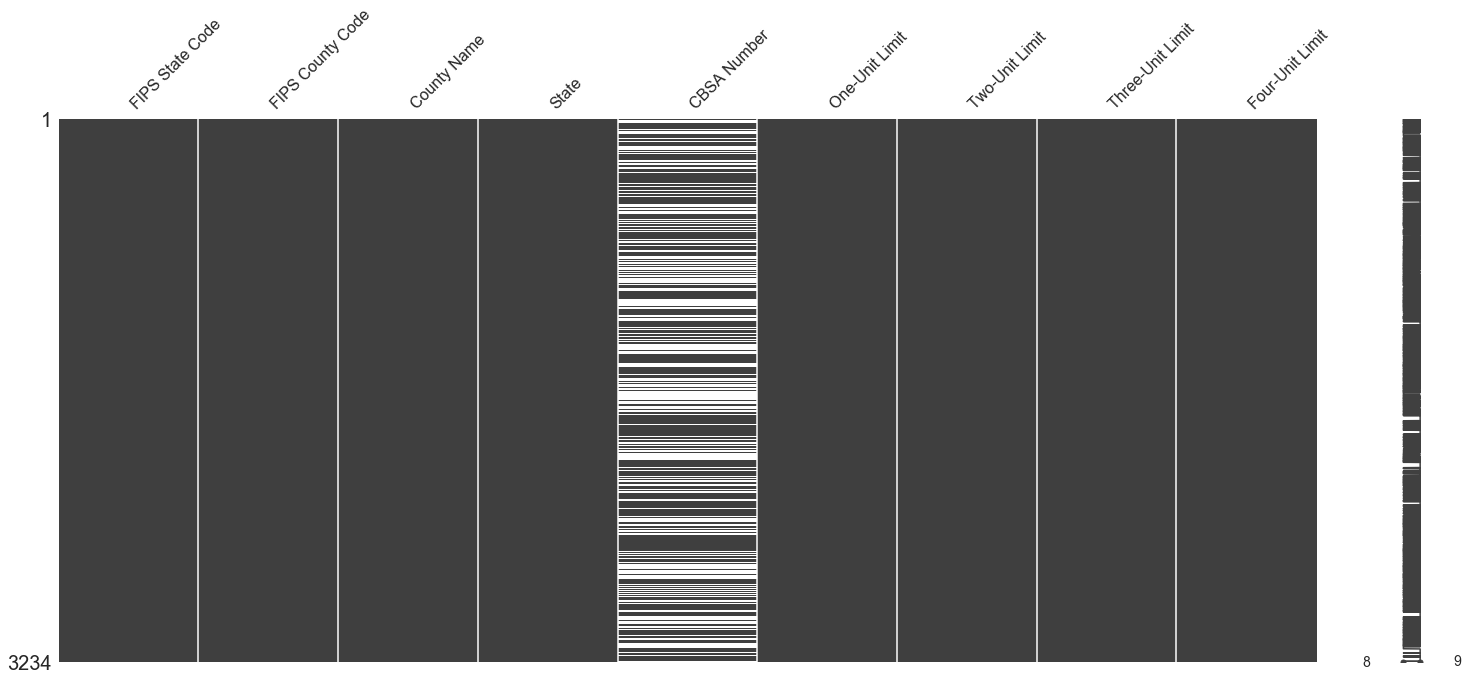

In [57]:
msno.matrix(loan_limits);

In [58]:
loan_limits.dtypes

FIPS State Code       int64
FIPS County Code      int64
County Name          object
State                object
CBSA Number         float64
One-Unit Limit        int64
Two-Unit Limit        int64
Three-Unit Limit      int64
Four-Unit Limit       int64
dtype: object

In [60]:
GEOCODE_URL = "https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx/GetGeocodeData"
JSON_HEADER = {'content-type':'application/json'}
def locate(address:str):
    try:
        geocode_data = {'sSingleLine': address, 'iCensusYear': "2017"}  
        r = requests.post(GEOCODE_URL, data = json.dumps(geocode_data), headers=JSON_HEADER)
        d = r.json()['d']
        if d["sStateCode"] and d["sCountyCode"]:
            return pd.Series([int(d["sStateCode"]), int(d["sCountyCode"])])
        else:
            return  pd.Series([np.nan, np.nan])
    except:
        print("Unexpected error:", sys.exc_info()[0])
        print("d={}".format(d))
        return pd.Series([np.nan, np.nan])

In [61]:
df_no_nan = df_no_nan[df_no_nan["conversion_length_d"] != 430]
print(len(df_no_nan))
df_no_nan = df_no_nan.drop(["converted"], axis=1)
df_no_nan.head()

1045


,amount,address,created,funded,conversion_length_m,conversion_length_d
1,413165.000,"124 Vignolia Court, Roseville CA 95747",2016-10-11,2016-11-07,0.887,27.000
6,504193.000,"10190 Brixton Pl, Suwanee GA 30024",2017-08-18,2017-09-18,1.019,31.000
8,275236.000,"1952 S St SE, Washington DC 20020",2017-09-23,2017-11-15,1.741,53.000
37,287472.000,"7498 NE 156th St, Kenmore WA 98028",2016-11-21,2016-12-30,1.281,39.000
40,254942.000,"3212-3214 W 157th St, Gardena CA 90249",2016-10-01,2016-11-18,1.577,48.000


In [62]:
df_no_nan[["state_code", "county_code"]] = df_no_nan["address"].apply(locate)
df_no_nan.head()

,amount,address,created,funded,conversion_length_m,conversion_length_d,state_code,county_code
1,413165.000,"124 Vignolia Court, Roseville CA 95747",2016-10-11,2016-11-07,0.887,27.000,6.000,61.000
6,504193.000,"10190 Brixton Pl, Suwanee GA 30024",2017-08-18,2017-09-18,1.019,31.000,13.000,117.000
8,275236.000,"1952 S St SE, Washington DC 20020",2017-09-23,2017-11-15,1.741,53.000,11.000,1.000
37,287472.000,"7498 NE 156th St, Kenmore WA 98028",2016-11-21,2016-12-30,1.281,39.000,53.000,33.000
40,254942.000,"3212-3214 W 157th St, Gardena CA 90249",2016-10-01,2016-11-18,1.577,48.000,6.000,37.000


In [63]:
print("Total={},\nNan={}".format(len(df_no_nan), df_no_nan.isnull().sum()))

Total=1045,
Nan=amount                  0
address                 0
created                 0
funded                  0
conversion_length_m     0
conversion_length_d     0
state_code             77
county_code            77
dtype: int64


In [64]:
df_no_nan.dropna(inplace=True)
len(df_no_nan)

968

In [65]:
df_no_nan.state_code = df_no_nan.state_code.astype(int)
df_no_nan.county_code = df_no_nan.county_code.astype(int)

In [68]:
# Saving the data
df_no_nan.to_csv("data/gps_loan.csv")

In [69]:
df_no_nan = pd.read_csv("data/gps_loan.csv", sep=",")
df_no_nan.head()

,Unnamed: 0,amount,address,created,funded,conversion_length_m,conversion_length_d,state_code,county_code
0,1,413165.000,"124 Vignolia Court, Roseville CA 95747",2016-10-11,2016-11-07,0.887,27.000,6,61
1,6,504193.000,"10190 Brixton Pl, Suwanee GA 30024",2017-08-18,2017-09-18,1.019,31.000,13,117
2,8,275236.000,"1952 S St SE, Washington DC 20020",2017-09-23,2017-11-15,1.741,53.000,11,1
3,37,287472.000,"7498 NE 156th St, Kenmore WA 98028",2016-11-21,2016-12-30,1.281,39.000,53,33
4,40,254942.000,"3212-3214 W 157th St, Gardena CA 90249",2016-10-01,2016-11-18,1.577,48.000,6,37
